# Non-parametric determination of the committor from non-equilbrium simulations. 50d model system

This notebook will be written in such a away so it can be used as a template for this type of analysis of other systems. 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="The raw code for this Python notebook is by default hidden for easier reading. Click here to toggle on/off the raw code."></form>''')

We import the required libraries

In [2]:
import math
import numpy as np
import npnelib as ne
%matplotlib inline
import matplotlib.pyplot as plt
import time
import tensorflow as tf

### Reading of the ensemble of trajectories
We start by reading the ensemble of short trajectories. Short trajectories in the ensemble are concatenated into a single long trajectory **Xtraj**, combined with trajectory index **itraj**=1,2,..., which shows to which short trajectory the current frame belongs to.

In [3]:
def u0(r):
    if r<2:return 5*(r-2)**2
    if r>12:return 5*(r-12)**2
    return 4*math.exp(-(r-6)**2) + 4*math.exp(-(r-8)**2)

def fr(r):
    if r<2:return -(r-2)*10-49/r
    if r>12:return -(r-12)*10 -49/r
    return 8*((r-6)*math.exp(-(r-6)**2)+(r-8)*math.exp(-(r-8)**2))-49/r

def comp_diffusion_multid(x0,force, D, nsteps, dtsave,dtsim,trjlen=10,Xstart=[]):
    start=time.time()
    nsteps2=int(dtsave/dtsim+1e-5)
    print (nsteps2,'internal steps')
    sigma=(2*D*dtsim)**0.5
    nd=len(x0)
    Xtraj=np.zeros((nsteps,nd),'f4')
    itraj=np.zeros((nsteps),'i')
    itc=1
    tl=trjlen+1
    xc=x0
    if len(Xstart)>0:
        ix=1
        xc=Xstart[ix,:]
    for istep in range(nsteps):
        if istep % (nsteps/10)==0:print (istep,time.time()-start)
        Xtraj[istep,:]=xc
        itraj[istep]=itc
        for istep2 in range(nsteps2):
            rc=sum(xc*xc)**0.5
            fxc=(force(rc)/rc*dtsim)*xc
            xt=xc+fxc
            rt=sum(xt*xt)**0.5
            fxt=(force(rt)/rt*dtsim)*xt
            xc=xc+(fxc+fxt)/2+np.random.randn(nd)*sigma

        tl-=1
        if tl<=0:
            if len(Xstart)>0:
                ix=ix+1
                xc=Xstart[ix,:]
            else:
                xc=np.random.random(nd)-0.5
                rc=sum(xc*xc)**0.5   
                xc=xc/rc*(np.random.random()*12+1)
            itc+=1
            tl=trjlen+1
        
    return Xtraj, itraj

if False: # set to True to compute and save trajectory
    x0=np.zeros(50,'f4')
    x0[0]=5
    np.random.seed(100)
    Xtraj,itraj=comp_diffusion_multid(x0,fr,D=1,nsteps=1000000,dtsave=.1,dtsim=0.001,trjlen=10)
    comment='''random.seed(100)
Xtraj,itraj=comp_diffusion_multid(x0,fr,D=1,nsteps=1000000,dtsave=.1,dtsim=0.001,trjlen=10)'''
    np.savez('X50traj_1', Xtraj=Xtraj,itraj=itraj,comment=comment)  


data=np.load('X50traj_1.npz')
Xtraj=data['Xtraj']
itraj=data['itraj']
print (data['comment'])

random.seed(100)
Xtraj,itraj=comp_diffusion_multid(x0,fr,D=1,nsteps=1000000,dtsave=.1,dtsim=0.001,trjlen=10)


### Projection on order parameter and definition of boundary states.

The multidimensional trajectory is projected on order parameter to define boundary states. The order parameter here is the radius $R(t)=\sqrt{\sum_{i=1}^{50} X(i,t)^2}$. 

The plot below shows the conventional (histogram based) free energy profile as a function of the order parameter. The free energy profile is different from the equilibrium one, i.e., $U_0$, confirming that the sampling is not equilibrium. 

We define the following boundary states for the committor, A: $R\le 2$ and B: $R\ge 12$.

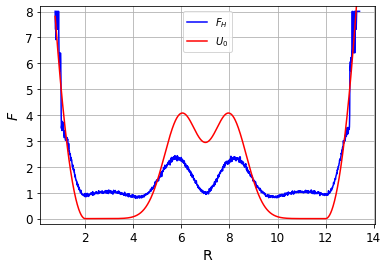

In [4]:
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize

rtraj=np.asarray([sum(X*X)**0.5 for X in Xtraj])

lx,lzh=ne.comp_Zh(rtraj,dx=0.01)
lf=[-math.log(z) for z in lzh]
lu=[u0(x) for x in lx]
def av(ly): return sum(ly)/len(ly) # computes average
m=av(lf)-av(lu) # aligns vertically the plots
lf=[y-m for y in lf]

plt.plot(lx,lf,'b-',label='$F_H$')
plt.plot(lx,lu,'r-',label='$U_0$')
plt.legend()
plt.xlabel('R')
plt.ylim(-0.2,8.2)
plt.grid()
_=plt.ylabel('$F$')

### Determination of the committor with the NPNEq algorithm
To run the NPNEq we need to provide the following time-series: $I_t(t)$, $I_b(t)$ and the initial committor $r(t)$:
 - $I_t(i)=1$ if **itraj[i]=itraj[i+1]** and 0 otherwise
 - $I_b(i)=1$ when point/frame i belongs to a boundary state and 0 otherwise
 - r(i)=0 or 1 when point/frame $i$ belongs to A or B and 0.5 otherwise.  

In [5]:
#Indicator function for trajectory, equals to 1 when itraj[t]==itraj[t+1]
It=np.ones_like(itraj,np.float64)
It[itraj!=np.roll(itraj,-1)]=0 

rA,rB=2,12 # order parameter values for boudary states A and B

#Indicator function, equals 1 on boundaries
Ib=np.zeros_like(rtraj,np.float64)
Ib[rtraj<=rA]=1 
Ib[rtraj>=rB]=1

# seed RC
r=np.ones_like(rtraj,np.float64)/2 # set to 0.5
r[rtraj<=rA]=0
r[rtraj>=rB]=1


#### Iterations:
 1. NPNEq where f(r,y) is a polynomial of 6-th degree
 2. every 10-th iteration we focus optimization on the boundary regions using as f(r) a polynomial of 16-th degree with an envelope: $f(r)=e^{-|r-r_0|/\Delta}\sum_{k=0}^{16} \alpha_k r^k$ for $\Delta =0.005$ and $r_0=0$ and $1$
 3. optimization of r by using as f(r) a polynomial of 16-th degree.
 
#### Stopping:
Iterations stop, when $||r-r_{-100}||<0.3$

#### Output
Every 100 iterations we print: iteration number, $||r-r_{-100}||$, and $\Delta r^2$.

In [6]:
np.random.seed(100)
ny=Xtraj.shape[1]
ro=r
lr1=[]
lr2=[]
for i in range(20001):
    # select random coordinate X_i as y
    j=np.random.randint(ny)
    y=Xtraj[:,j]/14
    y=y.astype(np.float64)
    
    r=ne.NPNEq(r,ne.basis_poly_ry(r,y,6),Ib,It)
    if i%10==0 and i>10:
        fenv=np.exp(-np.abs(1-r)/0.005)
        r=ne.NPNEq(r,ne.basis_poly_r(r,16,fenv=fenv),Ib,It)
    
        fenv=np.exp(-np.abs(0-r)/0.005)
        r=ne.NPNEq(r,ne.basis_poly_r(r,16,fenv=fenv),Ib,It)
       
    r=ne.NPNEq(r,ne.basis_poly_r(r,16),Ib,It)

    # compute \Delta r^2
    dr=r-tf.roll(r,-1,0)
    dr2=tf.tensordot(dr*It, dr, 1).numpy()
    lr2.append((i,dr2))
    
    if i%100==0:
        # compute ||r-r_{-100}||
        dr=r-ro
        dr2=tf.tensordot(dr,dr,1).numpy()
        dr2=dr2**0.5
        lr1.append((i,dr2))
        
        print (i,lr1[-1][1],lr2[-1][1])
        if dr2<0.3:break
        ro=r


qp=r.numpy()

0 94.41671187103134 15882.99271036661
100 365.27515392533087 2449.604075814456
200 37.332918113945055 2213.5747931365117
300 13.147905635318173 2148.0495686914173
400 7.164382258113875 2134.8519575333603
500 4.820144248438773 2126.6660838080097
600 3.5248646581606984 2120.4564294698926
700 2.793186542757555 2116.129181900058
800 2.5983952458303694 2113.6878514771884
900 2.261530415076503 2110.802554008271
1000 2.069698218291895 2107.698419847155
1100 1.9220917862179079 2106.46458918169
1200 1.6077780879581944 2104.5802934288845
1300 1.5010782975081567 2103.8613390144646
1400 1.5642956909298456 2102.146700473978
1500 1.2598074360578797 2101.45527642201
1600 1.1017185178087736 2100.1421503688907
1700 1.3932117461596931 2099.1882281651783
1800 1.0346086562480703 2098.3922769764213
1900 1.1211026604766234 2098.2018520389192
2000 0.9346674904938479 2097.464098798592
2100 1.0670248567003897 2095.8813982961487
2200 1.0007736521799997 2095.580585461064
2300 0.8039324600048067 2095.414772152635

### Convergence 

The Figure below shows $||r-r_{-100}||$ and $\Delta r^2$ as functions of iteration number. $||r-r_{-100}||$ decreases towards a small number as iteration number grows, illustrating the convergence of the NPNEq algorithm. $\Delta r^2$ converges to some limiting number as well.

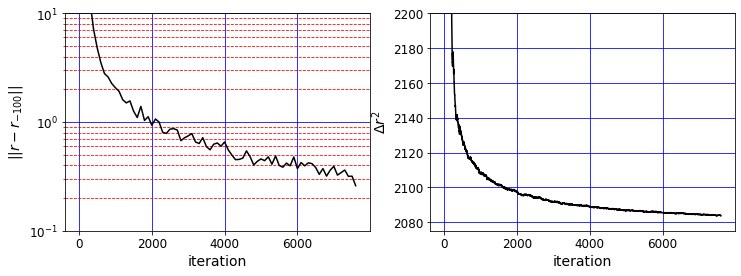

In [7]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
ax1.set(yscale='log',xlabel='iteration',ylabel='$||r-r_{-100}||$')
ax2.set(xlabel='iteration',ylabel='$\Delta r^2$')
for ax in(ax1,ax2):
        ax.grid(b=True, which='major', color='b', linestyle='-')
        ax.grid(b=True, which='minor', color='r', linestyle='--')
        
ar1=np.asarray(lr1)
ar2=np.asarray(lr2)
ax1.plot(ar1[:,0],ar1[:,1],'k')
ax1.set(ylim=(0.1,10))
ax2.plot(ar2[:,0],ar2[:,1],'k')
_=ax2.set(ylim=(2075,2200))

### The change of the putative committor function during the last 100 iterations

The Figure below shows that during the last 100 iteration the change of the committor values are bounded by $\pm 0.0015$, which shows that convergence is uniform and give a rough estimate of the accuracy of the putative committor.  

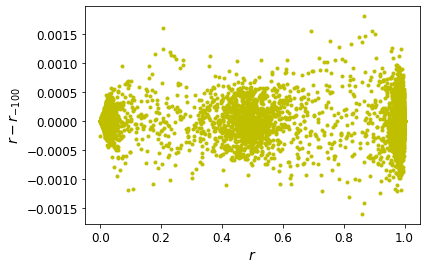

In [8]:
dr=r-ro
plt.plot(r[0:100000:10],dr[0:100000:10],'y.')
plt.ylabel('$r-r_{-100}$')
_=plt.xlabel('$r$')

From now on we refer to the putative committor time-series as **qp**.

### The validation criterion for non-equilibrium sampling. 

Left panel shows $Z_q(x,\Delta t)$ along the putative committor for $\Delta t=1,2,4,8$. The profiles are relatively constant with small fluctuations around the center. Note that without optimization focused on the boundary regions the profiles would show much larger fluctuations, especially close to boundaries.

Right panel shows $Z_q$ computed using the transition path segment summation. While it makes $Z_q$ for $\Delta t=1,2,4$ closer to each other, $Z_q$ for $\Delta t=8$ has large peaks at the boundaries illustrating problems with using the transition path segment summation for short trajectories.

Note that due to short length of trajectories, $Z_q$ profiles need to be rescaled by the factor $11-\Delta t$, i.e., the number of segments of length $\Delta t$ in the trajectory of 11 points (10 transitions).

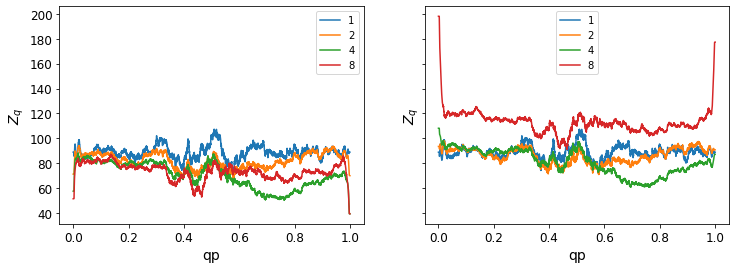

In [9]:
#qp=r.numpy()

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4),sharey=True)
for ax in(ax1,ax2):ax.set(xlabel='qp',ylabel='$Z_q$')

ldt=[2**i for i in range(4)]
dx=0.0001
for dt in ldt:
    lx,lzc1=ne.comp_Zq(qp,itraj=itraj,dx=dx,dt=dt)
    scale=(11-dt)/10
    lzc1=[zc1/scale for zc1 in lzc1]
    ax1.plot(lx,lzc1,label='%i' %dt)
    
    ekn=ne.comp_ekn_tp(qp,x0=0,x1=1,itraj=itraj,dx=dx,dt=dt)
    lx,lzc1=ne.comp_Zca_ekn(ekn,a=1,eq=False)
    scale=(11-dt)/10
    lzc1=[zc1/scale for zc1 in lzc1]
    ax2.plot(lx,lzc1,label='%i' %dt)

ax1.legend()
_=ax2.legend()

### Non-equilibrium free energy as a function of putative committor. 
Many points are close to the boundary states, indicating that one needs to additionally optimize this regions.

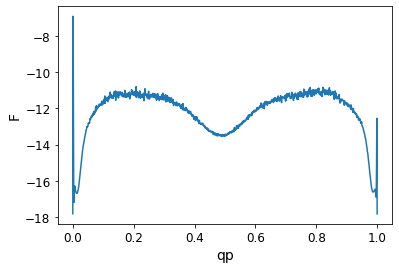

In [10]:
lx,lzh=ne.comp_Zh(qp,dx=0.001)
plt.plot(lx,-np.log(lzh),'-')
plt.ylabel('F')
_=plt.xlabel('qp')

### An initial fragment of the putative commiittor time-series. 

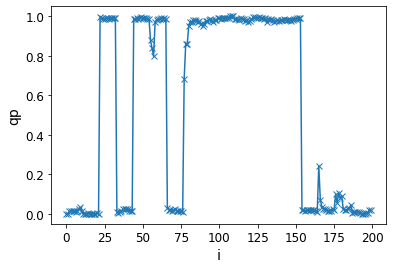

In [11]:
plt.plot(qp[:200],'-x')
plt.xlabel('i')
_=plt.ylabel('qp')

### Comparison of the putative committor with the analytical result.

The analytical equation for the one-dimensional committor is
$$q(x)=\int_A^x D^{-1}(r)e^{U_0(r)}dr/\int_A^B D^{-1}(r)e^{U_0(r)}dr.$$ Here D(r)=1. We compute the integral numerically. As one can see the agreement is reasonable. The difference can be attributed to relatively limited sampling.

In [12]:
lx=[0.001*i*10+2 for i in range(1001)]
ly=[math.exp(u0(x)) for x in lx]
from scipy.integrate import cumtrapz,simps
lq=cumtrapz(ly,lx,initial=0)
lq=lq/lq[-1]
qth=(lx,lq)

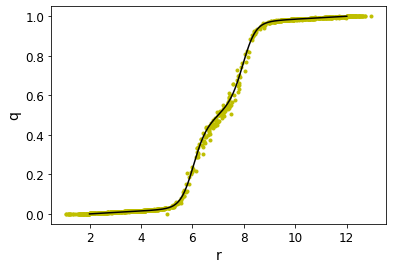

In [13]:
plt.plot(rtraj[0:100000:100],qp[0:100000:100],'y.')
plt.xlabel('r')
plt.ylabel('q')
_=plt.plot(qth[0],qth[1],'k-')

### Computing the reweighting factors $w_i$

The reweighting factor were computed with the NPNEw algorithm, using polynomials of 5th degree, which converged after ~70 iterations with $||r-r_{-1}||<10^{-4}$.

In [14]:
y=qp.astype(np.float64)
rw=np.ones_like(qp,np.float64)

for i in range(201):
    rwo=tf.identity(rw)
    rw=ne.NPNEw(rw,ne.basis_poly_ry(rw,y,5),It)
    
    if i%10==0: 
        dr=rw-rwo
        dr2=tf.tensordot(dr,dr,1).numpy()
        dr2=dr2**0.5
        print (i,dr2)
        if dr2<1e-4:break
wp=rw.numpy()
print()
print ('min w=%g, max w=%g, max w/min w =%g' %(min(wp),max(wp),max(wp)/min(wp)))

0 474.6998593867019
10 0.33295628721811893
20 0.08092361312285867
30 0.021142664085944913
40 0.005460136655299262
50 0.0014078394765650519
60 0.00036287834406455237
70 9.352471935830566e-05

min w=0.0791842, max w=1.67568, max w/min w =21.1618


### The reweighting factors as a function of radius.

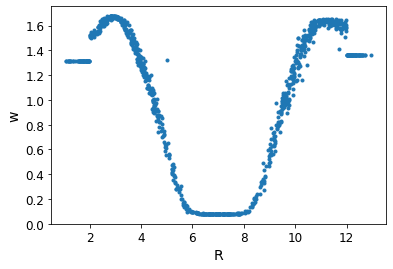

In [15]:
plt.plot(rtraj[0:100000:100],wp[0:100000:100],'.')
plt.xlabel('R')
_=plt.ylabel('w')

### Equilbrium free energy profile as a function of committor

The figure below show non-equilibrium $F(q)$, equilibrium (re-weighted) $F_w(q)$ and theoretical $F_{th}(q)$ free energy profiles as functions of putative committor. The last two are in good agreement.

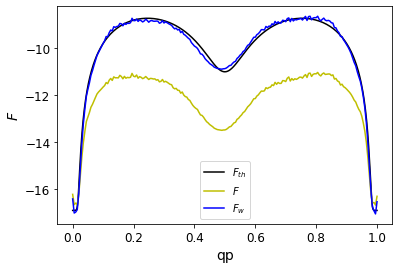

In [16]:
dx=0.005


lx1,lzh1=ne.comp_Zh(qp,dx=dx)
lf1=[-math.log(z) for z in lzh1 if z>0]

lx2,lzh2=ne.comp_Zh(qp,lw=wp*It,dx=dx)
lf2=[-math.log(z) for z in lzh2 if z>0]


lx,lq=qth
lf=[2*u0(x)-16.9 for x in lx] 

plt.plot(lq,lf,'k-',label='$F_{th}$')
plt.plot(lx1,lf1,'y-',label='$F$')
plt.plot(lx2,lf2,'b-',label='$F_w$')
plt.legend()
plt.xlabel('qp')
_=plt.ylabel('$F$')

### Equilibrium validation/optimality criterion $Z_{C,1}$

The Figure below shows that the reweighted, equilibrium, $Z_{C,1}(q,\Delta t)$ profiles are relatively constant with respect to q and $\Delta t$, confirming the self-consistency of the approach. I.e., that the committor coordinate and equilibrium weights are computed correctly. The relatively small fluctuations, bounded by $\pm 0.1$, can be attributed to relatively limited sampling. Large fluctuation very close to the boundaries are expected and are due to usage of simple $Z_{C,1}$, rather than the transition path segment summation.
 
### The equilbrium flux 
The equilibrium profile can be used to compute various properties of the kinetics exactly.
For example, the equilibrium flux can be estimated as $J_{AB}=N_{AB}/T$, where $T=N\Delta t$, is the total length of trajectory and $N_{AB}$ is the number of transitions from A to B. $N_{AB}$ can be computed as $$ N_{AB}^{-1}=\int_{q(A)}^{q(B)} Z_{C,1}^{-1}(q)dq=<Z_{C,1}^{-1}>[q(B)-q(A)]$$

For the committor, where $Z_{C,1}(q)=const$, $N_{AB}=Z_{C,1}/[q(B)-q(A)]$. 

dt=1: <Z_C,1>=117.951, J=0.00117951
dt=2: <Z_C,1>=120.433, J=0.00120433
dt=4: <Z_C,1>=125.502, J=0.00125502


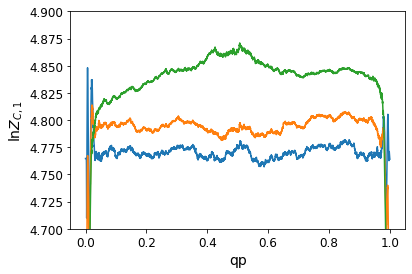

In [17]:
dx=0.0001
for dt in [1,2,4]:
    lx,lzc1=ne.comp_Zca(qp,a=1,itraj=itraj,lw=wp,dx=dx,dt=dt,eq=True)
    lzc1=[zc1*10/(11-dt) for zc1 in lzc1] # rescale for finite trajs length
    plt.plot(lx,np.log(lzc1),'-')
    zc1av=len(lzc1)/sum([1/zc1 for zc1 in lzc1])
    J=zc1av/(sum(wp*It))/0.1 
    print ('dt=%i: <Z_C,1>=%g, J=%g' %(dt,zc1av,J))
   
plt.xlabel('qp')
plt.ylabel('$\ln Z_{C,1}$')
_=plt.ylim((4.7,4.9))

To compute the flux analytically we note that equation for $N_{AB}$ is invariant with respect to the change of the variable, so we use
$$ N_{AB}^{-1}=\int_{x(A)}^{x(B)} Z_{C,1}^{-1}(x)dx$$
$$Z=\int e^{-U(x)} dx$$
and
$$J=N_{AB}/Z$$

The obtained fluxes are in good agreement.

In [18]:
lx=[0.001*i*12+1 for i in range(1001)]
ly=[math.exp(-u0(x)) for x in lx]
Z=simps(ly,lx)
lx=[0.001*i*10+2 for i in range(1001)]
ly=[math.exp(u0(x)) for x in lx]
Nab=1/simps(ly,lx)
print ('analytical flux = ',Nab/Z)

analytical flux =  0.0011862115293355432


### The equilibrium free energy profile as a function of natural coordinate $F(\tilde{q})$.

The committor can be rescaled to the natural coordinate $\tilde{q}$, along which the diffusion is constant, here, we take $D(\tilde{q})=1.$ Since for the original dynamics $D(r)=1,$ we should have $F(\tilde{q})\approx U_0(r).$ As we can see the agreement is quite good. Lower values at the boundaries for $F(\tilde{q})$ are due to the fact that all the points in state A and B are lumped into boundary points. 

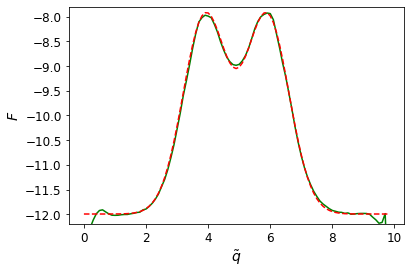

In [19]:
qn=ne.tonatural(qp,lw=wp*It,dx=0.0001,dtsim=.1,itraj=itraj)

lx1,lzh=ne.comp_Zh(qn,lw=wp*It,dx=0.1)
lf1=-np.log(lzh)
plt.plot(lx1,lf1,'g-',label='%i' %dt)

dx=2.1
lu=[u0((x+dx)) for x in lx1]
dy=av(lf1)-av(lu)
lu=[u0((x+dx))+dy+0.05 for x in lx1]

plt.ylabel('$F$')
plt.xlabel('$\\tilde{q}$')
plt.ylim(-12.2,-7.8)
_=plt.plot(lx1,lu,'r--')

### Figures for the paper

This part of the notebook prepares figures for the paper

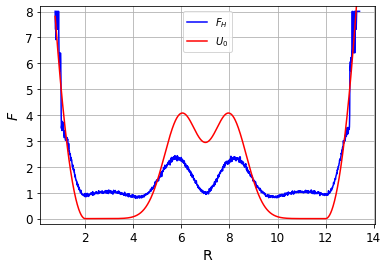

In [20]:
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title

lx,lzh=ne.comp_Zh(rtraj,dx=0.01)
lf=[-math.log(z) for z in lzh]

lu=[u0(x) for x in lx]
m=av(lf)-av(lu) # aligns vertically the plots
lf=[y-m for y in lf]

plt.plot(lx,lf,'b-',label='$F_H$')
plt.plot(lx,lu,'r-',label='$U_0$')
plt.legend()
plt.xlabel('R')
plt.ylim(-0.2,8.2)
plt.grid()
_=plt.ylabel('$F$')
_=plt.savefig('fig1.pdf',dpi=600)

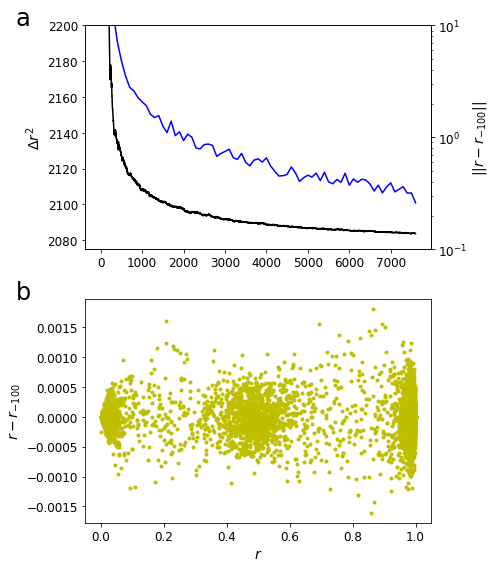

In [21]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(7,8))
        
ar1=np.asarray(lr1)
ar2=np.asarray(lr2)

ax1b=ax1.twinx()

ax1b.set(yscale='log',xlabel='iteration',ylabel='$||r-r_{-100}||$')
ax1b.plot(ar1[:,0],ar1[:,1],'b')
ax1b.set(ylim=(0.1,10))
ax1.set(ylabel='$\Delta r^2$')
ax1.plot(ar2[:,0],ar2[:,1],'k')
_=ax1.set(ylim=(2075,2200))

dr=r-ro
ax2.plot(r[0:100000:10],dr[0:100000:10],'y.')
ax1.text(-.2,1,'a',fontsize=24,transform=ax1.transAxes)
ax2.text(-.2,1,'b',fontsize=24,transform=ax2.transAxes)
_=ax2.set(xlabel='$r$',ylabel='$r-r_{-100}$')
plt.tight_layout()
_=plt.savefig('fig2.pdf',dpi=600)

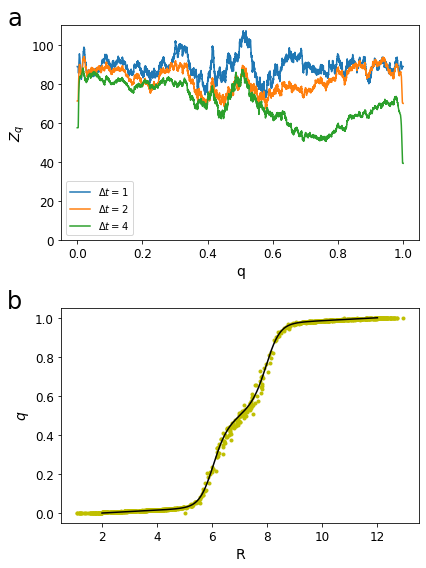

In [22]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(6,8))
ax1.set(xlabel='q',ylabel='$Z_q$',ylim=(0,110))
ax2.set(xlabel='R',ylabel='$q$')

ldt=[2**i for i in range(3)]
dx=0.0001
for dt in ldt:
    lx,lzc1=ne.comp_Zq(qp,itraj=itraj,dx=dx,dt=dt)
    scale=(11-dt)/10
    lzc1=[zc1/scale for zc1 in lzc1]
    ax1.plot(lx,lzc1,label='$\Delta t=%i$' %dt)

ax2.plot(rtraj[0:100000:100],qp[0:100000:100],'y.')
ax2.plot(qth[0],qth[1],'k-')

ax1.text(-.15,1,'a',fontsize=24,transform=ax1.transAxes)
ax2.text(-.15,1,'b',fontsize=24,transform=ax2.transAxes)
    
ax1.legend()
fig.tight_layout()
_=fig.savefig('fig3.pdf',dpi=600)

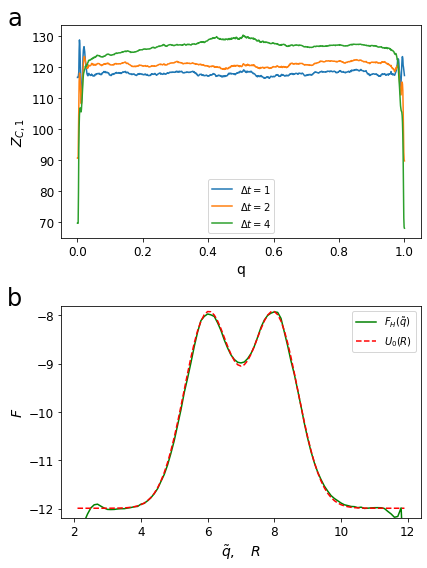

In [23]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(6,8))
dx=0.001
for dt in [1,2,4]:
    lx,lzc1=ne.comp_Zca(qp,a=1,itraj=itraj,lw=wp,dx=dx,dt=dt,eq=True)
    lzc1=[zc1*10/(11-dt) for zc1 in lzc1] # rescale for finite trajs length
    ax1.plot(lx,lzc1,'-',label='$\Delta t=%i$' %dt)
   
ax1.set(xlabel='q',ylabel='$Z_{C,1}$')

dx=2.1
lx1,lzh=ne.comp_Zh(qn,lw=wp*It,dx=0.1)
lx1=[x+dx for x in lx1]
lf1=-np.log(lzh)
ax2.plot(lx1,lf1,'g-',label='$F_H(\\tilde{q})$')

lu=[u0((x)) for x in lx1]
dy=av(lf1)-av(lu)
lu=[u0(x)+dy+0.05 for x in lx1]

ax2.plot(lx1,lu,'r--',label='$U_0(R)$')
ax2.set(xlabel='$\\tilde{q},\quad R$',ylabel='$F$',ylim=(-12.2,-7.8))

ax1.text(-.15,1,'a',fontsize=24,transform=ax1.transAxes)
ax2.text(-.15,1,'b',fontsize=24,transform=ax2.transAxes)

ax1.legend()
ax2.legend()
fig.tight_layout()
_=fig.savefig('fig4.pdf',dpi=600)